# Replica project

### Model

In [1]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd

from tqdm import tqdm
import torch

from dataloader_replica import ReplicaDataset

from torch.utils.data import DataLoader
from glob import glob

from utils import *
from metrics import *
from model_replica import ReplicaNet

import numpy as np
from torch.optim import lr_scheduler

from store_embeddings import *
from utils import * 

path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'



In [2]:
data = pd.read_csv(data_dir + 'dedup_data_sample.csv').drop(columns=['Unnamed: 0', 'level_0'])
print(data.shape)
data.head()

(12862, 47)


uid                           cluster   index  \
0  f2c17f970b114294a0403d5d4e59386f  f2c17f970b114294a0403d5d4e59386f  111077   
1  e165258d8e6142acac6d5617cc091b8a  e165258d8e6142acac6d5617cc091b8a  103106   
2  a266c68d59454209a9c0c3ec0e9bf99d  a266c68d59454209a9c0c3ec0e9bf99d   74427   
3  4a617aa8a9cd4d89874221e2beec9931  4a617aa8a9cd4d89874221e2beec9931   34405   
4  bba4f0d0294f420b90310cfe333c03ad  bba4f0d0294f420b90310cfe333c03ad   85957   

  Drawer ImageNumber                   Author  \
0    74A         745            MITSUOKI Tosa   
1   114B         739  SORIA Giovanni Battista   
2    39A         269   EVERDINGEN Allaert van   
3    89A         468                  SEC XVI   
4    84B         729               SEC XVI ex   

                                       Description            AuthorOriginal  \
0             Episodio del "Genji Monogatari" Dis.            MITSUOKI, Tosa   
1                                           Atrio.  SORIA, Giovanni Battista   
2  Paesaggio ecoa earri penna e pennello se 193 mm    EVERDINGEN Allaert van   
3                              Leonendi San Marco.                  SEC. XVI   
4                                       Cherubino.               SEC. XVI ex   

            AuthorULANLabel      AuthorULAN  ...  \
0            Mitsuoki, Tosa  ulan:500121170  ...   
1  Soria, Giovanni Battista  ulan:500020294  ...   
2   Everdingen, Allaert van  ulan:500115159  ...   
3                       NaN             NaN  ...   
4                       NaN             NaN  ...   

                                        CardboardURL  \
0  https://dhlabsrv4.epfl.ch/iiif_cini/74A%2F74A_...   
1  https://dhlabsrv4.epfl.ch/iiif_cini/114B%2F114...   
2  https://dhlabsrv4.epfl.ch/iiif_cini/39A%2F39A_...   
3  https://dhlabsrv4.epfl.ch/iiif_cini/89A%2F89A_...   
4  https://dhlabsrv4.epfl.ch/iiif_cini/84B%2F84B_...   

                                            ImageURL      uid_connection  \
0  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  Not uid connection   
1  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  Not uid connection   
2  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  Not uid connection   
3  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  Not uid connection   
4  https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...  Not uid connection   

   img1 img2 type annotated               uid2  set               path  
0   NaN  NaN  NaN       NaN    74A/74A_745.jpg  NaN    74A/74A_745.jpg  
1   NaN  NaN  NaN       NaN  114B/114B_739.jpg  NaN  114B/114B_739.jpg  
2   NaN  NaN  NaN       NaN    39A/39A_269.jpg  NaN    39A/39A_269.jpg  
3   NaN  NaN  NaN       NaN    89A/89A_468.jpg  NaN    89A/89A_468.jpg  
4   NaN  NaN  NaN       NaN    84B/84B_729.jpg  NaN    84B/84B_729.jpg  

[5 rows x 47 columns]

In [3]:
device = 'cpu'
model = ReplicaNet('resnext-101', device)
#model.load_state_dict(torch.load(data_dir + "model_weights_" + 'resnext-101'))

In [4]:
for name, param in model.named_parameters():
    print(name, param.grad)

model.0.weight None
model.1.weight None
model.1.bias None
model.4.0.conv1.weight None
model.4.0.bn1.weight None
model.4.0.bn1.bias None
model.4.0.conv2.weight None
model.4.0.bn2.weight None
model.4.0.bn2.bias None
model.4.0.conv3.weight None
model.4.0.bn3.weight None
model.4.0.bn3.bias None
model.4.0.downsample.0.weight None
model.4.0.downsample.1.weight None
model.4.0.downsample.1.bias None
model.4.1.conv1.weight None
model.4.1.bn1.weight None
model.4.1.bn1.bias None
model.4.1.conv2.weight None
model.4.1.bn2.weight None
model.4.1.bn2.bias None
model.4.1.conv3.weight None
model.4.1.bn3.weight None
model.4.1.bn3.bias None
model.4.2.conv1.weight None
model.4.2.bn1.weight None
model.4.2.bn1.bias None
model.4.2.conv2.weight None
model.4.2.bn2.weight None
model.4.2.bn2.bias None
model.4.2.conv3.weight None
model.4.2.bn3.weight None
model.4.2.bn3.bias None
model.5.0.conv1.weight None
model.5.0.bn1.weight None
model.5.0.bn1.bias None
model.5.0.conv2.weight None
model.5.0.bn2.weight None
model

In [5]:
import torch.nn.functional as F

triplet_loss = nn.TripletMarginLoss(
    margin=0.0001, reduction='mean' # to be optimized margin
)

triplet_loss = nn.TripletMarginWithDistanceLoss(
    distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)
    )
    
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-4) # to be optimized lr and method
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01) # to be optimized step and gamma


In [6]:
replica_dir='/mnt/project_replica/datasets/cini/'
dts = {x: ReplicaDataset(data_dir + 'dataset/abc_' + x + '_100.csv', data_dir + 'subset.csv', replica_dir, data_dir, x, 320) for x in ['train', 'val']}
dataset_sizes = {x: len(dts[x]) for x in ["train", "val"]}
train_dataloaders = {x: DataLoader(dts[x], batch_size=1, shuffle=False) for x in ["train", "val"]}

model.7.2.conv2.weight tensor([[[[-5.7703e-06, -1.4441e-05, -8.8058e-06],
          [-1.5981e-05,  1.2620e-05,  4.0580e-06],
          [-5.3010e-06, -1.0982e-05, -6.5341e-06]],

         [[-1.7559e-05, -2.5107e-05, -9.2102e-06],
          [-8.5431e-06,  2.4253e-05,  8.6703e-06],
          [ 3.5440e-06,  4.9509e-06,  2.6688e-06]],

         [[-2.6836e-05, -3.9817e-05, -3.0760e-05],
          [-1.1896e-05, -7.2101e-06, -2.8356e-05],
          [-3.4852e-06,  1.8030e-06, -9.6410e-06]],

         ...,

         [[-7.2839e-06, -1.2521e-05, -3.6559e-06],
          [-6.4350e-06,  2.4015e-05, -3.2698e-06],
          [-6.1970e-06, -1.2923e-07,  1.0511e-06]],

         [[-1.0900e-05, -1.0579e-05, -4.5748e-06],
          [-1.3236e-07,  1.6936e-05, -8.4153e-07],
          [ 6.7556e-07,  3.9190e-07,  2.6431e-06]],

         [[-2.1805e-05, -7.8843e-06, -1.0705e-05],
          [-1.5276e-05,  1.6667e-05, -5.5647e-06],
          [-4.8014e-06, -8.0270e-06,  4.0370e-06]]],


        [[[ 1.1966e-06, -6.886

0it [00:00, ?it/s]

model.7.2.conv2.weight tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
       

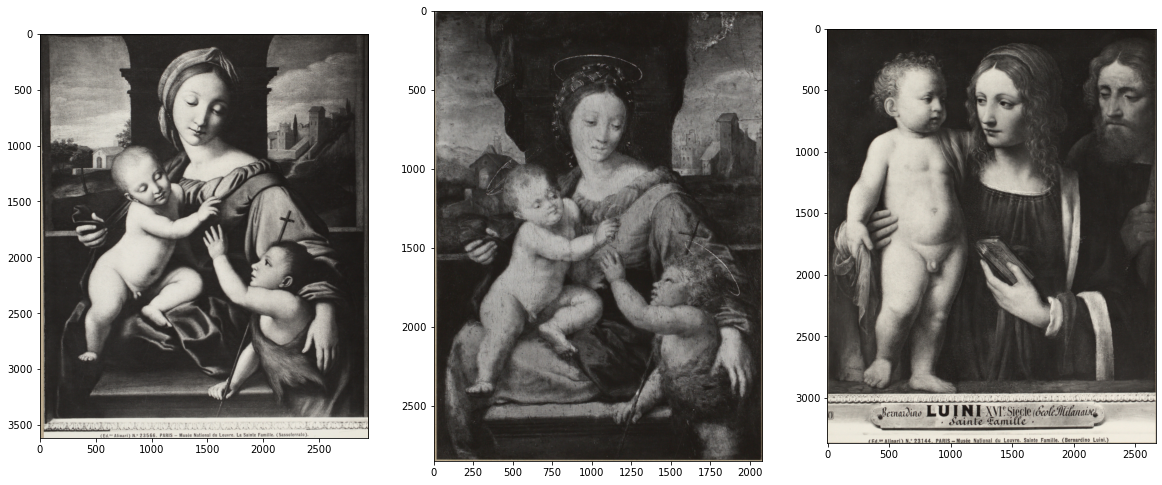

1it [00:07,  7.88s/it]

tensor(0.9970, grad_fn=<MeanBackward0>)


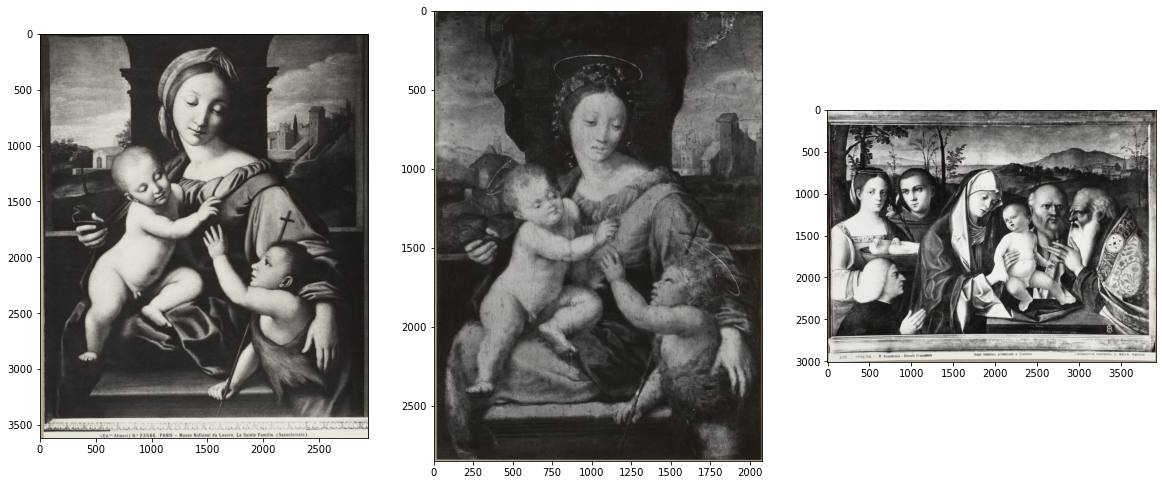

2it [00:16,  8.08s/it]

tensor(0.9998, grad_fn=<MeanBackward0>)


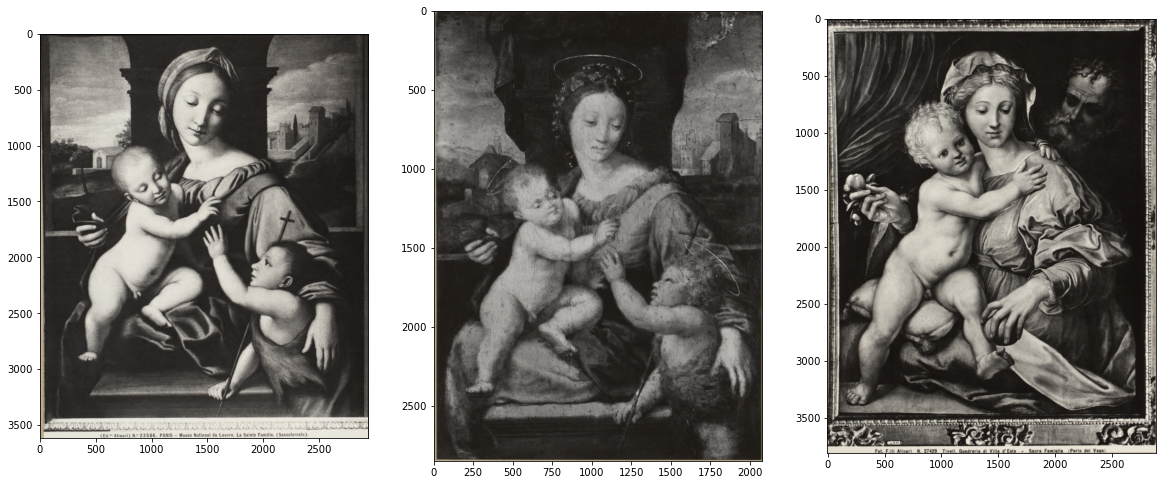

3it [00:24,  8.34s/it]

tensor(1.0002, grad_fn=<MeanBackward0>)


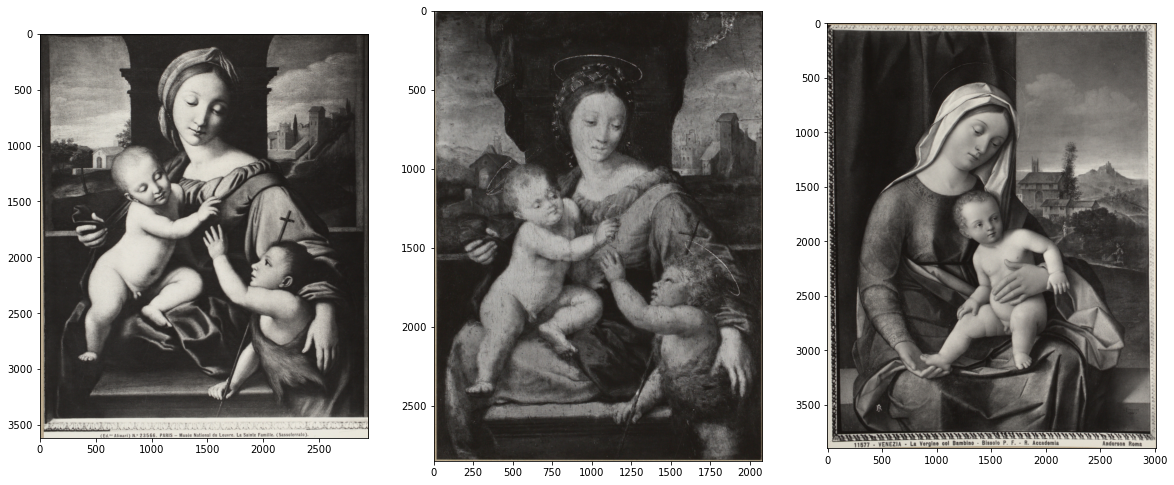

4it [00:33,  8.64s/it]

tensor(0.9996, grad_fn=<MeanBackward0>)


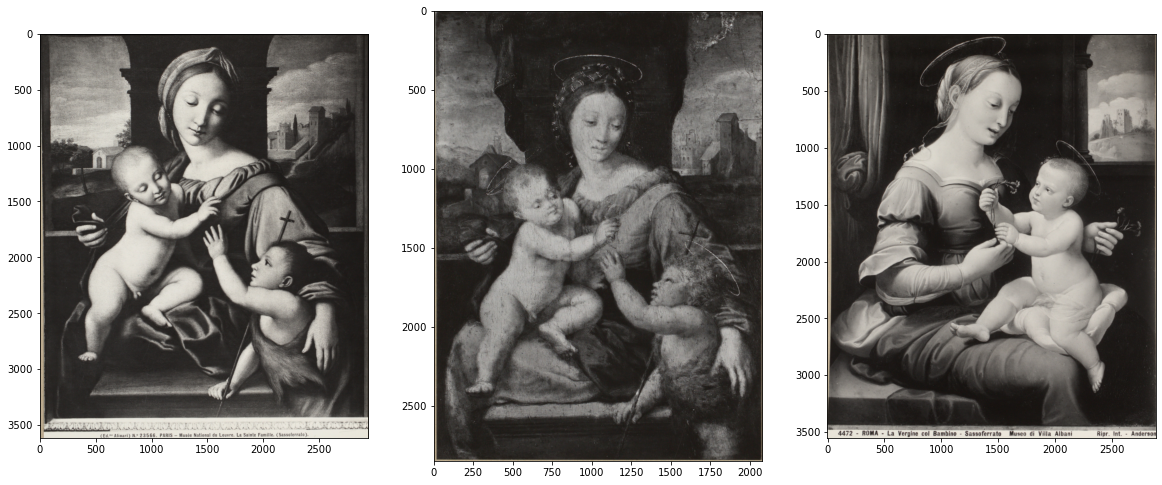

5it [00:42,  8.72s/it]

tensor(0.9997, grad_fn=<MeanBackward0>)


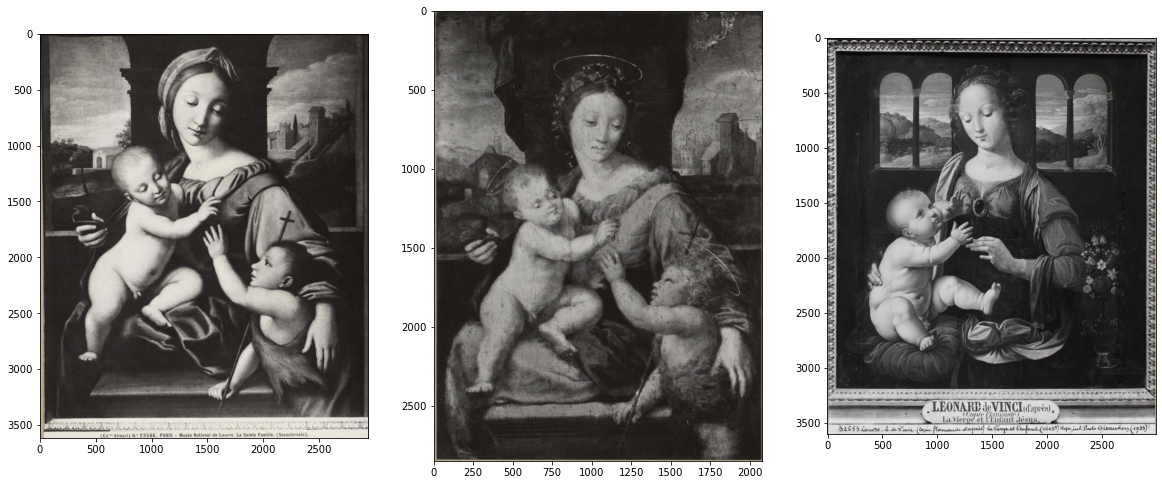

6it [00:51,  8.64s/it]

tensor(0.9996, grad_fn=<MeanBackward0>)


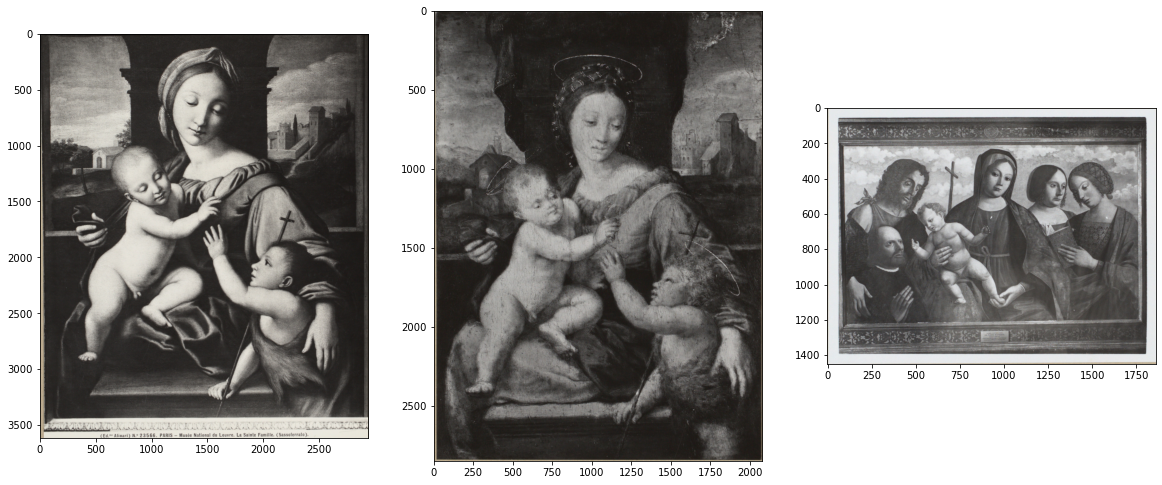

6it [00:58,  9.78s/it]

tensor(0.9995, grad_fn=<MeanBackward0>)


In [8]:
for param in model.modules():
    if isinstance(param, nn.BatchNorm2d):
        param.requires_grad = False

for name, param in model.named_parameters():
    if name == 'model.7.2.conv2.weight':
        print(name, param.grad)
    

for i, list_ in tqdm(enumerate(train_dataloaders['train'])):
    
    [a, b, c] = list_
    a = a.squeeze(1).to(device)
    b = b.squeeze(1).to(device)
    c = c.squeeze(1).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

                    
    # Forward pass
    A, B, C = model(a, b, c)
    # Compute and print loss
    loss = triplet_loss(A, B, C)
    
    if i == 0:
        for name, param in model.named_parameters():
            if name == 'model.7.2.conv2.weight':
                print(name, param.grad)

    # backward + optimize only if in training phase
    loss.backward()
    optimizer.step()


    if i == 0:
        for name, param in model.named_parameters():
            if name == 'model.7.2.conv2.weight':
                print(name, param.grad)
     
    # statistics
    running_loss = loss.item() * a.size(0)
    dts['train'].__show_images__(i)
    print(loss)
            

    scheduler.step()

    epoch_loss = running_loss / dataset_sizes['train']

    if i > 5:
        break
            

In [9]:
for name, param in model.named_parameters():
    if name == 'model.7.2.conv2.weight':
        print(name, param.grad)

model.7.2.conv2.weight tensor([[[[-5.7703e-06, -1.4441e-05, -8.8058e-06],
          [-1.5981e-05,  1.2620e-05,  4.0580e-06],
          [-5.3010e-06, -1.0982e-05, -6.5341e-06]],

         [[-1.7559e-05, -2.5107e-05, -9.2102e-06],
          [-8.5431e-06,  2.4253e-05,  8.6703e-06],
          [ 3.5440e-06,  4.9509e-06,  2.6688e-06]],

         [[-2.6836e-05, -3.9817e-05, -3.0760e-05],
          [-1.1896e-05, -7.2101e-06, -2.8356e-05],
          [-3.4852e-06,  1.8030e-06, -9.6410e-06]],

         ...,

         [[-7.2839e-06, -1.2521e-05, -3.6559e-06],
          [-6.4350e-06,  2.4015e-05, -3.2698e-06],
          [-6.1970e-06, -1.2923e-07,  1.0511e-06]],

         [[-1.0900e-05, -1.0579e-05, -4.5748e-06],
          [-1.3236e-07,  1.6936e-05, -8.4153e-07],
          [ 6.7556e-07,  3.9190e-07,  2.6431e-06]],

         [[-2.1805e-05, -7.8843e-06, -1.0705e-05],
          [-1.5276e-05,  1.6667e-05, -5.5647e-06],
          [-4.8014e-06, -8.0270e-06,  4.0370e-06]]],


        [[[ 1.1966e-06, -6.886

In [ ]:
embeddings = np.load(
                    data_dir + 'embeddings/resnext-101_avg_480' + ".npy",
                    allow_pickle=True,
                )        
embeddings.shape
train_test = data[data["set"].notnull()].reset_index() 